### Import

In [1]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import shutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

In [15]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чистим папку, если чт-то пошло не так
shutil.rmtree('/content/drive/MyDrive/course_work_nn/train')

### Create DataFrame

In [ ]:
!cd /content/drive/MyDrive/course_work_nn && unzip -q train.zip

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [4]:
class_weight = {}
for i, j  in enumerate(set(df.emotion)):
    count_of_samples = df[df['emotion'] == j].agg('count')[0]
    total = df.shape[0]
    weight = (1 / count_of_samples) * (total / 9.0)

    class_weight[i] = weight

In [6]:
class_weight

{0: 0.8183468236448369,
 1: 1.8024851431658562,
 2: 0.825024727992087,
 3: 0.933781136300028,
 4: 0.8794348674152566,
 5: 0.938192452617963,
 6: 1.1024319323288396,
 7: 0.7918921484857117,
 8: 1.7624933967247756}

In [5]:
# преобразуем имена файлов(убрать все кроме имени)
for i in range(len(df)):  
  # df['image_path'][i] = df['image_path'][i].split('/')[-1]
  df['image_path'][i] = df['image_path'][i].replace("./train/", "")

<ipython-input-5-2c8617ea5363>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'][i] = df['image_path'][i].replace("./train/", "")


In [7]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,anger/0.jpg,anger
1,1,anger/1.jpg,anger
2,2,anger/10.jpg,anger
3,3,anger/100.jpg,anger
4,4,anger/1000.jpg,anger


In [6]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,0:2], df['emotion'], test_size=0.2, stratify=df['emotion'])

In [7]:
train = pd.concat([train_x, train_y], axis = 1).reset_index(drop=True)
test = pd.concat([test_x, test_y], axis = 1).reset_index(drop=True)

In [8]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(train.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_train = pd.concat([train, tmp], axis = 1)

In [9]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(test.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_test = pd.concat([test, tmp], axis = 1)

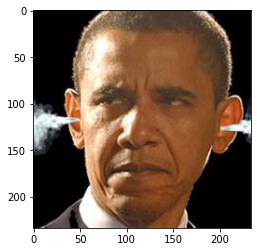

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/course_work_nn/train/anger/100.jpg')
plt.imshow(img)

### DataGenerator

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.01,
                            zoom_range=0.1,
#                             horizontal_flip=True,
                            fill_mode='nearest'
                             )

datagen_test = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=128)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                shuffle=True,
                                                batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


### VGGFace

Используем предобученную VGGFace, так как уже обучена на лицах людей.

In [16]:
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface

  Cloning https://github.com/rcmalli/keras-vggface.git to c:\users\admin\appdata\local\temp\pip-req-build-svufwquj


  Running command git clone -q https://github.com/rcmalli/keras-vggface.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-svufwquj'


In [19]:
# !pip install git+https://github.com/rcmalli/keras-vggface.git
# !pip install keras_applications --no-deps
filename = "E:/anaconda/Lib/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [40]:
base_model = VGGFace(weights='vggface', include_top=False, input_shape=(128,128,3), pooling='max')

In [41]:
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 128, 128, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 128, 128, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 64, 64, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 64, 64, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 128)     

In [42]:
base_model.trainable = False

fine_tune_at = 17
# # # все слои до -- заморозим
for layer in base_model.layers[:16]:
    layer.trainable =  False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512,   kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 activity_regularizer=regularizers.L2(1e-4),
                       activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 14,981,961
Trainable params: 267,273
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
model.compile(optimizer = 'Adam',
              loss = tf.keras.losses.CategoricalCrossentropy(1e-4),
              metrics = ['categorical_accuracy'])

In [45]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main3_vggface.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

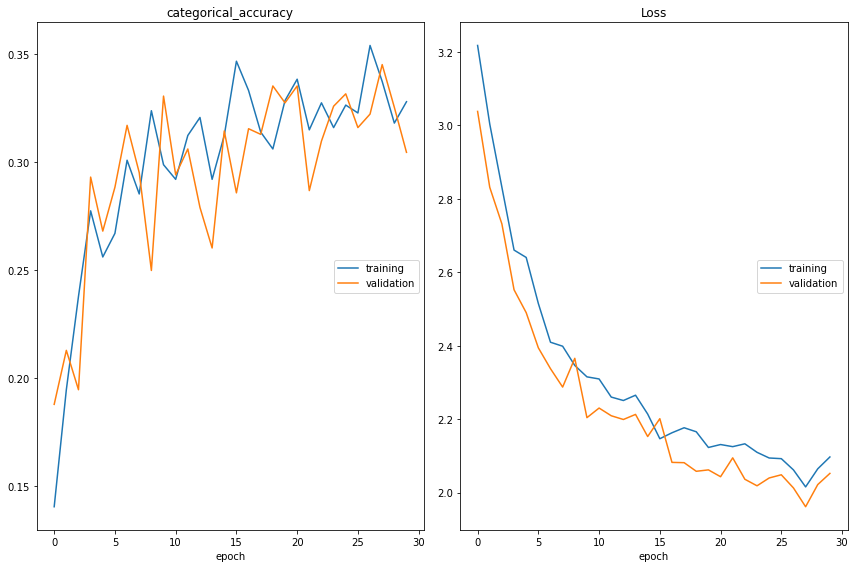

categorical_accuracy
	training         	 (min:    0.141, max:    0.354, cur:    0.328)
	validation       	 (min:    0.188, max:    0.345, cur:    0.305)
Loss
	training         	 (min:    2.016, max:    3.218, cur:    2.097)
	validation       	 (min:    1.962, max:    3.038, cur:    2.052)
30/30 [==============================] - 405s 14s/step - loss: 2.0972 - categorical_accuracy: 0.3281 - val_loss: 2.0524 - val_categorical_accuracy: 0.3047


In [46]:
history = model.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### Imagenet

In [13]:
from tensorflow.keras.applications import VGG16

In [20]:
#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
for layer in base_model.layers[:-3]:
    layer.trainable = False
 # Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002310EB86F70> False
<keras.layers.convolutional.Conv2D object at 0x000002310CE20EE0> False
<keras.layers.convolutional.Conv2D object at 0x000002310C402D30> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310CE20A90> False
<keras.layers.convolutional.Conv2D object at 0x000002310F601310> False
<keras.layers.convolutional.Conv2D object at 0x000002310F601850> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310F5FABB0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F60C910> False
<keras.layers.convolutional.Conv2D object at 0x000002310F615820> False
<keras.layers.convolutional.Conv2D object at 0x000002310F615940> False
<keras.layers.pooling.MaxPooling2D object at 0x000002310F615BB0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F61C1C0> False
<keras.layers.convolutional.Conv2D object at 0x000002310F623D60> False
<keras.layers.convolutional.Conv2D object at 0x000002310F61A160> False
<ker

In [22]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(base_model)
 
# Add new layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, 
                                 kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 activity_regularizer=regularizers.L2(1e-4),
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(9, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 21,139,785
Trainable params: 11,144,713
Non-trainable params: 9,995,072
_________________________________________________________________


In [18]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main3_imagenet_augm.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

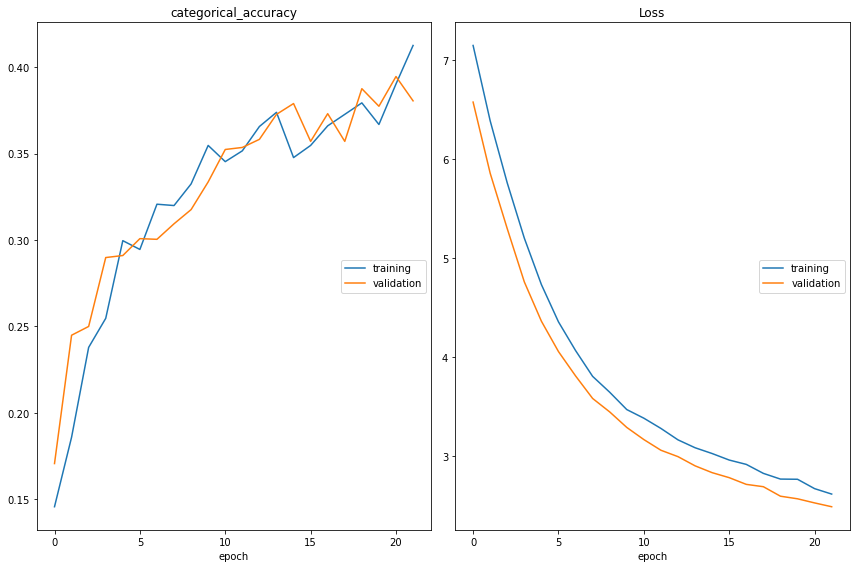

categorical_accuracy
	training         	 (min:    0.146, max:    0.412, cur:    0.412)
	validation       	 (min:    0.171, max:    0.395, cur:    0.380)
Loss
	training         	 (min:    2.613, max:    7.149, cur:    2.613)
	validation       	 (min:    2.485, max:    6.576, cur:    2.485)
20/20 [==============================] - 1648s 84s/step - loss: 2.6132 - categorical_accuracy: 0.4125 - val_loss: 2.4851 - val_categorical_accuracy: 0.3805
Epoch 23/40
13/20 [==================>...........] - ETA: 5:07 - loss: 2.6010 - categorical_accuracy: 0.3996

In [ ]:
history = model.fit( train_generator_1,
                      steps_per_epoch=20,
                      epochs = 40,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

In [20]:
model = tf.keras.models.load_model('model_main3_imagenet_augm.h5')

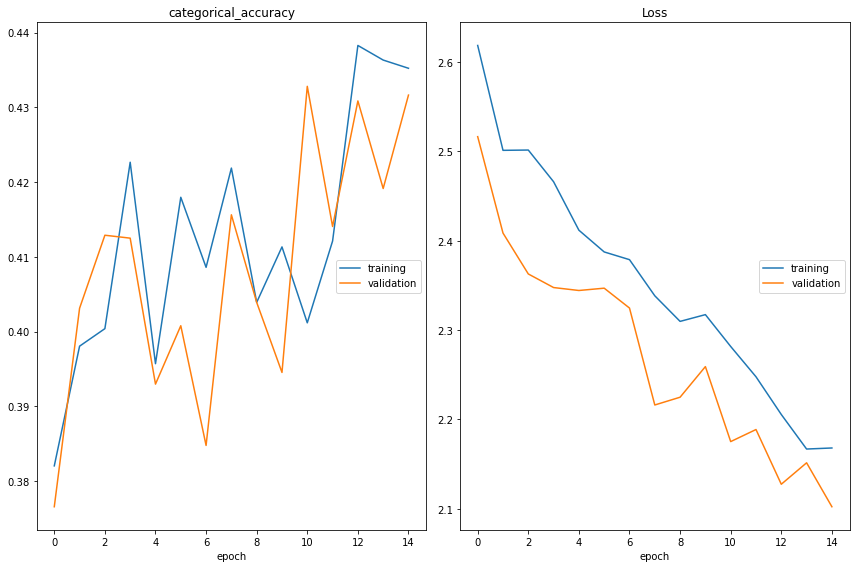

categorical_accuracy
	training         	 (min:    0.382, max:    0.438, cur:    0.435)
	validation       	 (min:    0.377, max:    0.433, cur:    0.432)
Loss
	training         	 (min:    2.167, max:    2.619, cur:    2.168)
	validation       	 (min:    2.102, max:    2.517, cur:    2.102)
20/20 [==============================] - 1828s 93s/step - loss: 2.1680 - categorical_accuracy: 0.4352 - val_loss: 2.1022 - val_categorical_accuracy: 0.4316
Epoch 16/16
20/20 [==============================] - ETA: 0s - loss: 2.1315 - categorical_accuracy: 0.4437 

In [ ]:
history = model.fit( train_generator_1,
                      steps_per_epoch=20,
                      epochs = 16,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

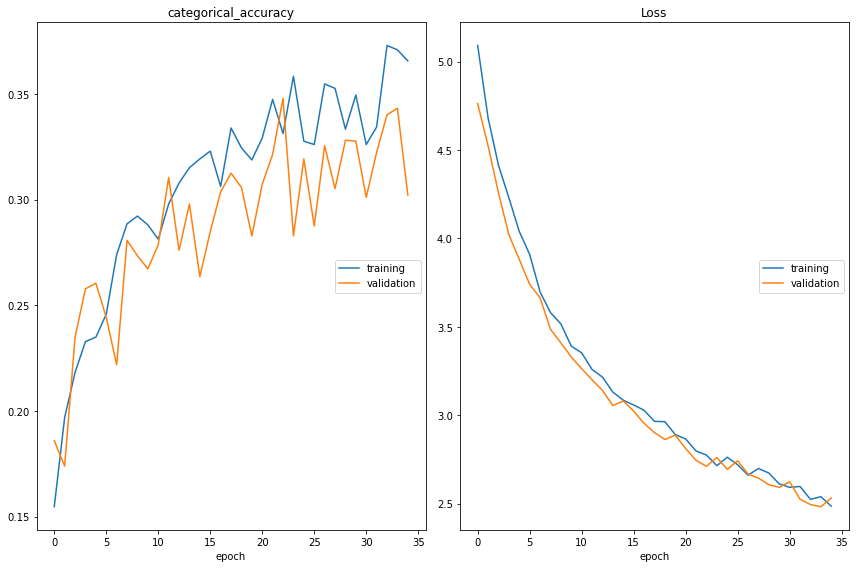

categorical_accuracy
	training         	 (min:    0.155, max:    0.373, cur:    0.366)
	validation       	 (min:    0.174, max:    0.348, cur:    0.302)
Loss
	training         	 (min:    2.486, max:    5.092, cur:    2.486)
	validation       	 (min:    2.483, max:    4.763, cur:    2.532)
30/30 [==============================] - 396s 13s/step - loss: 2.4859 - categorical_accuracy: 0.3656 - val_loss: 2.5317 - val_categorical_accuracy: 0.3021


In [44]:
# no dropout,  augmentation 256 dense, 2 layers trained
history = model.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 35,
                      validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

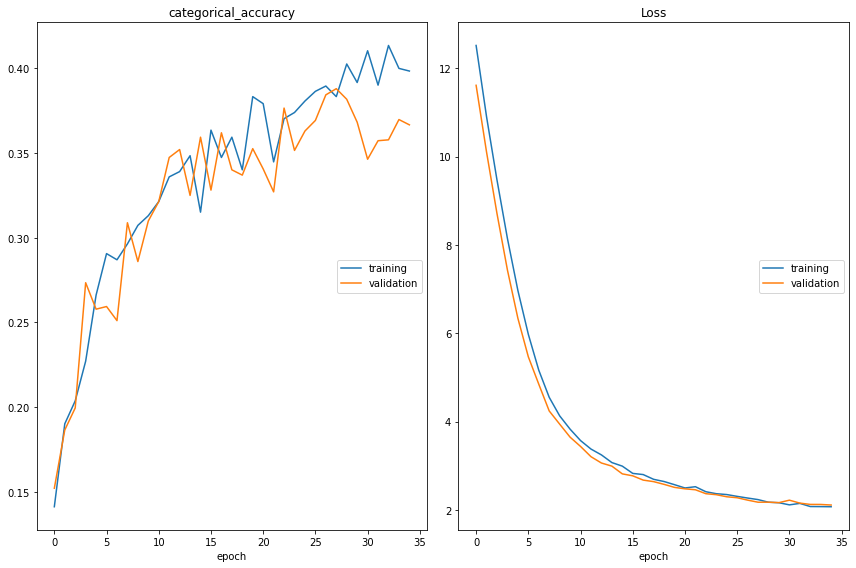

categorical_accuracy
	training         	 (min:    0.141, max:    0.414, cur:    0.398)
	validation       	 (min:    0.152, max:    0.388, cur:    0.367)
Loss
	training         	 (min:    2.072, max:   12.515, cur:    2.072)
	validation       	 (min:    2.111, max:   11.613, cur:    2.111)
30/30 [==============================] - 480s 16s/step - loss: 2.0719 - categorical_accuracy: 0.3984 - val_loss: 2.1107 - val_categorical_accuracy: 0.3667


In [30]:
# with augmentation(full)
history = model.fit( train_generator_1,
                      steps_per_epoch=30,
                      epochs = 35,
                      validation_data = test_generator_1,
                      validation_steps = 30,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### Inference

In [ ]:
def show_pred(images, labels, predicted_labels=None):
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(images[i])
        plt.imshow(img)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

In [ ]:
idxs = np.random.choice(np.arange(len(test_generator.filenames)), 1, replace=False)
fnames = []
labels = []
preds = []
for i in idxs:
    fnames.append('/content/drive/MyDrive/course_work_nn/train/' + test_generator_1.filenames[i])
    labels.append(list(set(df['emotion']))[test_generator.labels[i]])
    preds.append(list(set(df['emotion']))[np.argmax(predicted_labels[i])])
show_pred(fnames, labels, preds)

### One foto inference

In [ ]:
def preprocess_img(img):
    """препроцессинг фото перед подачей в сеть"""
    img = img.resize((128,128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.
    img = np.expand_dims(img, axis = 0)
    return img

In [ ]:
%%timeit -n 10 -r 10

img = image.load_img('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/test_kaggle/test_kaggle/1.jpg')
img = preprocess_img(img)
pred = model01.predict(img)

### Generating a file for Kaggle

In [ ]:
shutil.rmtree('/content/drive/MyDrive/course_work_nn/test_kaggle')

In [ ]:
!cd /content/drive/MyDrive/course_work_nn/ && unzip -q test_kaggle.zip

In [2]:
model01 = tf.keras.models.load_model('model_main3_imagenet_augm.h5')

In [3]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

In [4]:
datagen = ImageDataGenerator(rescale = 1/255.)

In [8]:
test_generator = datagen.flow_from_directory(directory = 'test_kaggle/test_kaggle/',
                                       target_size=(128,128),
                                       class_mode='categorical',
                                       classes=['.'],
                                       shuffle = False,
                                       batch_size=1)

Found 5000 images belonging to 1 classes.


In [11]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model01.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
    predictions.append(emotions[np.argmax(i)])


filenames = []
for i in test_generator.filenames:
    filn = i.replace(".\\",'')
    filenames.append(filn)

results=pd.DataFrame({"image_path":filenames,
                      "emotion":predictions})

<ipython-input-11-b8b3761d1d87>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model01.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)


5000/5000 [==============================] - 1217s 243ms/step


In [12]:
results.to_csv('model_imagenet_augm.csv', index=False)